In [ ]:
import numpy as np
import os
import random

In [ ]:
class BowVectorizer:
    def __init__(self):
        self._words_per_file = []
        self.X = []
        self.vocabulary = []

    def fit(self, X_raw):
        all_words = set()
        for review in X_raw:
            tokens = review.strip().split(" ")
            all_words.update(tokens)
        self.vocabulary = sorted(list(all_words))
        
    def transform(self, X_raw):
        count = 0
        for review in X_raw:
            vector = np.zeros(len(self.vocabulary))
            tokens = review.strip().split(" ")
            for i, w in enumerate(self.vocabulary):
                if w in set(tokens):
                    vector[i] = 1
            count += 1
            self.X.append(vector)
        return np.array(self.X).T

In [ ]:
filepaths = []
for root, dirs, files in os.walk(os.getcwd() + "/review_polarity/txt_sentoken/"):
    for file in files:
        if os.path.splitext(file)[1] == '.txt':
            filepaths.append(os.path.join(root, file))
random.shuffle(filepaths)

X_raw = []
y = []

for filepath in filepaths:
    if "pos" in filepath:
        with open(filepath, "r") as f:
            X_raw.append(f.read())
        y.append(1)

    if "neg" in filepath:
        with open(filepath, "r") as f:
            X_raw.append(f.read())
        y.append(-1)

vectorizer = BowVectorizer()
vectorizer.fit(X_raw)
X = vectorizer.transform(X_raw)

In [ ]:
class GDClassifier:

    def __init__(self, eta, alpha, epoch=100, batch=100):
        self.eta = eta
        self.epoch = epoch
        self.batch = batch
        self.alpha = alpha
        self.w = np.random.normal(0, 0.1, (np.size(X, 0), 1)) # 56198, 1

    def fit(self, X, y):
        for i in range(self.epoch):            
            for j in range(np.size(X, 1) // self.batch):
                j_start = self.batch * j
                j_end = self.batch * (j + 1)
                X_batch = X[:, j_start:j_end] # 56198 * 100
                y_batch = y[j_start:j_end] # 100

                grad_w = self.compute_gradient(X_batch, y_batch, self.alpha)
                self.w -= self.eta * grad_w

    def predict(self, X):
        result = np.zeros(np.size(X, 1))
        for i, product in enumerate(np.dot(self.w.T, X).ravel()):
            if product > 0:
                result[i] = 1
            elif product < 0:
                result[i] = -1
        return result

    def score(self, X, y):
        predicted = self.predict(X)
        correct = 0
        for i, sentiment in enumerate(y):
            if predicted[i] == sentiment:
                correct += 1
        return correct * 100 / len(y)

    def loss(self, X, y):
        result = 0
        for i in range(np.size(X, 1)): 
            Xi = X[:, i].reshape(np.size(X, 0) ,1)
            result += max(0, 1 - y[i] * np.dot(self.w.T, Xi))
        return 0.5 * self.alpha * pow(np.linalg.norm(self.w), 2) + result

    def compute_gradient(self, X, y, l):
        sum = np.zeros((np.size(X, 0), 1))
        for i in range(np.size(X, 1)):
            Xi = X[:, i].reshape(np.size(X, 0) ,1)
            if y[i] * np.dot(self.w.T, Xi) >= 1:
                pass
            else:
                sum += - y[i] * Xi
        return l * self.w + sum

In [ ]:
model = GDClassifier(eta=0.001, alpha=0.1)
model.fit(X, y)
omega = model.w.ravel()

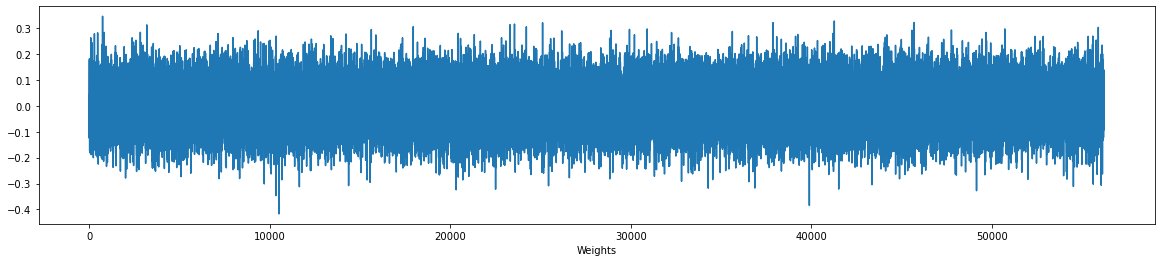

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.plot(omega)
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

In [81]:
idx = np.argsort(np.abs(omega))

print("                Word\tWeight\tOccurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
    print("%20s   %.3f\t%i " % (vectorizer.vocabulary[i], omega[i], np.sum([vectorizer.vocabulary[i] in d for d in X_raw])))

                Word	Weight	Occurences
               graft   -0.309	3 
               waste   -0.311	246 
                bink   -0.312	11 
              
louis   0.312	3 
               flaws   0.313	103 
                fond   0.316	61 
             nothing   -0.317	594 
                mess   -0.318	315 
            go-round   0.321	5 
              others   0.321	378 
               purse   -0.321	4 
   fashion-conscious   -0.322	1 
          sensuality   0.322	5 
              earth-   -0.324	9 
        pseudo-asian   0.327	1 
              stupid   -0.328	227 
               
bore   0.346	4 
               awful   -0.347	156 
                plot   -0.384	1002 
                 bad   -0.417	825 


In [56]:
X_train = X[:, 0:int(np.size(X, 1) * 0.8)] # 56198 * 1600
y_train = y[0:int(np.size(X, 1) * 0.8)] # 1600

X_test = X[:, int(np.size(X, 1) * 0.8):] # 56198 * 400
y_test = y[int(np.size(X, 1) * 0.8):] # 400

In [96]:
parameter_distribution = {'learning_rate': np.random.permutation(np.exp(np.linspace(np.log(0.0001), np.log(3), 10))),
                          'reguliser_dampening': np.random.permutation(np.exp(np.linspace(np.log(0.0001), np.log(3), 10)))}

best_params = {}

print("Learning rate:\tReg.dampening:\tTraining set accuracy:")

for i, lea_ra in enumerate(parameter_distribution["learning_rate"]):
    reg_damp = parameter_distribution["reguliser_dampening"][i]
    model = GDClassifier(eta=lea_ra, alpha=reg_damp)
    model.fit(X_train, y_train)
    training_accuracy = model.score(X_train, y_train)
    best_params[(lea_ra, reg_damp)] = training_accuracy
    print("%.5f\t\t%.5f\t\t%.2f%%" % (lea_ra, reg_damp, training_accuracy))
    
best_parameters = sorted(best_params.items(), key=lambda d:d[1], reverse=True)[0][0]
best_learning_rate = best_parameters[0]
best_reguliser_dampening = best_parameters[1]
print("Best parameters: %.5f, %.5f" % (best_learning_rate, best_reguliser_dampening))

Learning rate:	Reg.dampening:	Training set accuracy:
0.09655		0.09655		99.69%
0.03071		0.00977		100.00%
0.00031		0.00031		100.00%
0.00010		3.00000		98.19%
0.95425		0.95425		49.88%
0.30353		0.00010		100.00%
3.00000		0.03071		50.12%
0.00311		0.00099		100.00%
0.00977		0.30353		99.94%
0.00099		0.00311		100.00%
Best parameters: 0.03071, 0.00977


In [97]:
model = GDClassifier(eta=best_learning_rate, alpha=best_reguliser_dampening)
model.fit(X_train, y_train)
test_acc = model.score(X_test, y_test)
print("Test set accuracy %.2f%%" % test_acc)

Test set accuracy 85.00%


Short Report:

    The file paths were written in and stored in a list. It was shuffled for the convenience of splitting the data randomly later.
    
    Tokenization was done by splitting the white spaces with the purpose of making the time complexity quadratic instead of cubic. And the vector generation process took about 20 minutes.
    
    The model uses a batch gradient descent with batch size 100, so that the gradient updates every 100 data points. The default epoch was set to 100. The training process stops if the loss keeps decreasing by less than 0.001 (converge) or going up (diverge) for 5 times summed up.
    
    We can see that words like "bad, awful, stupid, nothing, mess" contribute to a negative label very much, and words like "flaws, fond, fun" contribute to a positive label very much. Because these words appears frequently (from 200 times to around 1000 times) in the reviews that are labeled as negative or positive respectively.
    
    The hyperparameters are generated randomly from an exponentially spaced grid where each of the values is about 3 times as large as the previous one. Then the learning rate and reguliser dampening were picked randomly from the grid. From the training result, we can see that the training accuracy is the best when learning rate being 0.03071 and reguliser dampening being 0.00977. And the corresponding test set accuracy is 85%. It is a bit weird to see the training accuracy being 100% at first, but since it is just a binary classification problem and the training set is small, this could happen.